# PySynphot notebook

In [1]:
import pysynphot as S
import csv 
import os
import pandas as pd
from scipy.interpolate import interp1d
import astropy.units as u
from astropy import constants as const
from astropy.io import fits
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


NBBANDS=6
band_to_number={'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2={'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
filtercolor=['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color={0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number={'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col=['b','g','r','y','k']

WLMIN=3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

# LSST collectif surface
Deff=642.3 # effective radius in cm
Seff = np.pi*Deff**2/4  # in cm2
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m2
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

EXPOSURE=30.0                      # LSST Exposure time

graphtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\4cm1612bm_tmg.fits
 comptable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\5182153pm_tmc.fits
thermtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


# Cadence

In [2]:
df = pd.read_csv("Downloads\Cadences dobservation des nuages de Magellan/cadence_lmc_baseline2018a.csv", index_col=0)
df

,observationId,night,observationStartMJD,fiveSigmaDepth,filter,airmass,skyBrightness,seeingFwhmEff,fieldId,fieldRA,fieldDec
0,8476,11,59863.363137,22.906131,z,1.231287,18.659079,0.757448,236,79.825808,-65.928086
1,10032,13,59865.306991,21.987304,y,1.386800,17.826026,0.751198,116,77.606893,-73.293777
2,10160,13,59865.365718,21.894638,y,1.315613,17.861954,0.841153,150,81.777206,-70.757749
3,10161,13,59865.366169,21.944466,y,1.267955,17.897698,0.822736,190,84.972540,-68.155026
4,10165,13,59865.367986,21.959869,y,1.232333,17.922088,0.824816,236,79.825808,-65.928086
...,...,...,...,...,...,...,...,...,...,...,...
753,2372036,3648,63500.371725,23.393553,r,1.375268,20.153390,1.243669,116,77.606893,-73.293777
754,2372039,3648,63500.373102,23.480260,r,1.278194,20.210373,1.190228,178,76.364237,-68.470535
755,2372040,3648,63500.373553,23.375525,r,1.328889,20.176793,1.284311,150,81.777206,-70.757749
756,2372049,3648,63500.377604,23.414925,r,1.285710,20.198968,1.256791,190,84.972540,-68.155026


# LSST throughput

In [3]:
df_LSST = pd.read_csv("D:\\Projet de recherche\Stage\lsst_throughput.csv", index_col=0)
df_LSST

,wl,u,g,r,i,z,y
0,300,0.000711,0.000000,0.000000,0.000034,0.000000,0.000000
1,301,0.000440,0.000000,0.000000,0.000155,0.000000,0.000000
2,302,0.000591,0.000000,0.000000,0.000072,0.000000,0.000000
3,303,0.000022,0.000000,0.000000,0.000034,0.000000,0.000000
4,304,0.000229,0.000000,0.000000,0.000034,0.000000,0.000000
...,...,...,...,...,...,...,...
896,1196,0.000029,0.000298,0.000088,0.000121,0.000560,0.016426
897,1197,0.000024,0.000357,0.000084,0.000150,0.000630,0.016413
898,1198,0.000016,0.000427,0.000080,0.000187,0.000711,0.016397
899,1199,0.000012,0.000501,0.000076,0.000235,0.000802,0.016303


In [4]:
f10 = open("D:\Projet de recherche\Stage\out\RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.out","r")

temp10 = [r.split() for r in f10]

wl_10 = [float(r[0]) for r in temp10]
atmo_10 = [float(r[1]) for r in temp10]

f11 = open("D:\Projet de recherche\Stage\out\RT_MPL_pp_us_sa_rtvis_z11_wv40_oz30_cld0000.out","r")

temp11 = [r.split() for r in f11]

wl_11 = [float(r[0]) for r in temp11]
atmo_11 = [float(r[1]) for r in temp11]

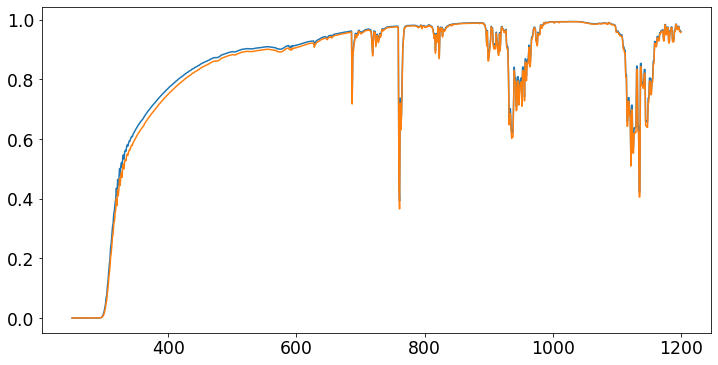

In [5]:
plt.plot(wl_10,atmo_10)
plt.plot(wl_11,atmo_11)

In [6]:
temp = []
lambdas = []
z = []
for i in range(0, 21):
    string = "D:\Projet de recherche\Stage\out\RT_MPL_pp_us_sa_rtvis_z" + str(10+i) + "_wv40_oz30_cld0000.out"
    f = open(string, 'r')
    temp.append([r.split() for r in f])
    z.append([float(r[1]) for r in temp[i]])
lambdas = [float(r[0]) for r in temp[0]]
type(z[1][0])

float

In [7]:
with open('D:\Projet de recherche\Stage\Atmosphere.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    big_boi = [[lambdas[i]] + [t[i] for t in z] for i in range(len(lambdas))]
    writer.writerow(["wl","z1","z1.1","z1.2","z1.3","z1.4","z1.5","z1.6","z1.7","z1.8","z1.9","z2","z2.1","z2.2","z2.3","z2.4","z2.5","z2.6","z2.7","z2.8","z2.9","z3"])
    writer.writerows(big_boi)

In [8]:
df_atmo = pd.read_csv("D:\Projet de recherche\Stage\Atmosphere.csv", index_col=0)
df_atmo

,z1,z1.1,z1.2,z1.3,z1.4,z1.5,z1.6,z1.7,z1.8,z1.9,...,z2.1,z2.2,z2.3,z2.4,z2.5,z2.6,z2.7,z2.8,z2.9,z3
wl,,,,,,,,,,,,,,,,,,,,,
250.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
251.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
252.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
253.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
254.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196.0,0.977899,0.975739,0.973588,0.971446,0.969313,0.967189,0.965074,0.962967,0.960870,0.958781,...,0.954628,0.952565,0.950510,0.948464,0.946426,0.944396,0.942375,0.940362,0.938357,0.936361
1197.0,0.977899,0.975739,0.973588,0.971446,0.969313,0.967189,0.965074,0.962967,0.960870,0.958781,...,0.954628,0.952565,0.950510,0.948464,0.946426,0.944396,0.942375,0.940362,0.938357,0.936361
1198.0,0.963689,0.960293,0.956937,0.953621,0.950344,0.947105,0.943904,0.940740,0.937613,0.934521,...,0.928445,0.925458,0.922506,0.919587,0.916701,0.913847,0.911025,0.908235,0.905475,0.902745


In [9]:
#import transmission
#trans_atmo = []

#for i in range (len(lambdas)) : 
    
   # trans_atmo.append(float(transmission.atmo(lambdas[i],1)))
    


In [10]:
#Atmospheric transmission plot  

#plt.plot(lambdas, trans_atmo)

# Vega spectrum in photlam observed by HST

(0.0, 12000.0)

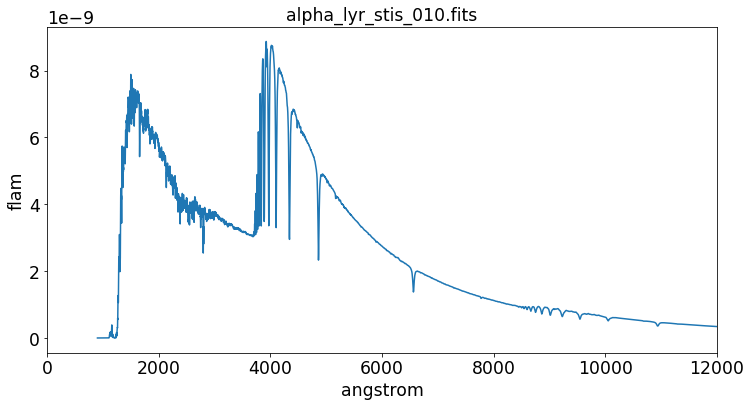

In [11]:
#Vega through LSST

sp = S.Vega
plt.plot(sp.wave, sp.flux)
plt.title(os.path.basename(S.Vega.name))
plt.xlabel(S.Vega.waveunits)
plt.ylabel(S.Vega.fluxunits)
plt.xlim([0,12000])

In [12]:
from astropy.io import ascii

Atmo = ascii.read('D:\Projet de recherche\Stage\out\RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.out', names=['wave', 'throughput'])
throughput = Atmo['throughput']  # Second column
wave = Atmo['wave']
#atmo_10bis = S.FileBandpass('D:\Projet de recherche\Stage\out\RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.out', thrucol = throughput)

In [13]:
with open('D:\Projet de recherche\Stage\lsst_throughput.csv', 'r') as inp, open('D:\Projet de recherche\Stage\lsst_throughput.txt', 'w') as out:
    for line in inp:
        line = line.replace(',', ' ')
        out.write(line)

In [14]:
LSST = ascii.read('D:\Projet de recherche\Stage\lsst_throughput.csv', names=['rows', 'wave', 'throughput_u', 'throughput_g', 'throughput_r', 'throughput_i', 'throughput_z', 'throughput_y'], data_start = 1)

throughput_u = LSST['throughput_u']
throughput_g = LSST['throughput_g']
throughput_r = LSST['throughput_r']
throughput_i = LSST['throughput_i']
throughput_z = LSST['throughput_z']
throughput_y = LSST['throughput_y']
wave_LSST = LSST['wave']
LSST

rows,wave,throughput_u,throughput_g,throughput_r,throughput_i,throughput_z,throughput_y
int32,int32,float64,float64,float64,float64,float64,float64
0,300,0.0007109999999999999,0.0,0.0,3.4e-05,0.0,0.0
1,301,0.00043999999999999996,0.0,0.0,0.000155,0.0,0.0
2,302,0.0005909999999999999,0.0,0.0,7.2e-05,0.0,0.0
3,303,2.2000000000000003e-05,0.0,0.0,3.4e-05,0.0,0.0
4,304,0.000229,0.0,0.0,3.4e-05,0.0,0.0
5,305,2.6e-05,0.0,0.0,2.8999999999999997e-05,0.0,0.0
6,306,0.000199,0.0,0.0,4e-05,0.0,0.0
7,307,0.000478,0.0,0.0,6.7e-05,0.0,0.0
8,308,9e-06,0.0,0.0,2e-05,0.0,0.0


# LSST and atmosphere throughput from file

In [15]:
LSST_u = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["u"].values, name = "u")
LSST_g = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["g"].values, name = "g")
LSST_r = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["r"].values, name = "r")
LSST_i = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["i"].values, name = "i")
LSST_z = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["z"].values, name = "z")
LSST_y = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["y"].values, name = "y")

atmo_10 = S.ArrayBandpass(wave*10, throughput, name="atm, airmass 1.0")

Wave = df_LSST["wl"]*10
Wavelength = np.array(Wave)

# Defining Bandpass in each band

In [16]:
bp_u = LSST_u * atmo_10
bp_g = LSST_g * atmo_10
bp_r = LSST_r * atmo_10
bp_i = LSST_i * atmo_10
bp_z = LSST_z * atmo_10
bp_y = LSST_y * atmo_10

# Plot bandpass (LSST x atmosphere) in each band

Text(0.5, 1.0, 'Bandpass')

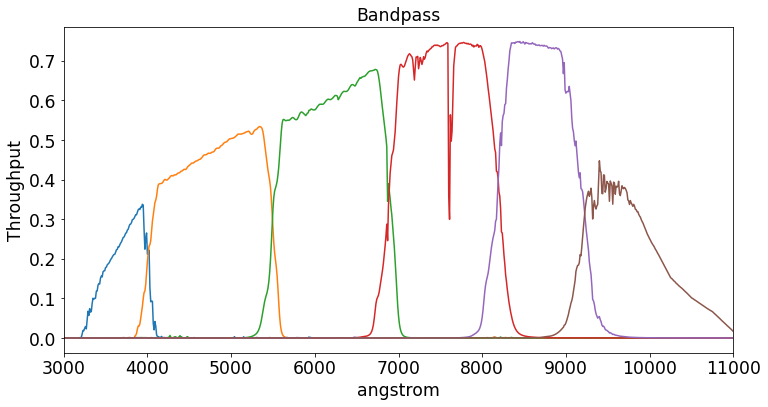

In [17]:
plt.plot(bp_u.wave, bp_u.throughput)
plt.plot(bp_g.wave, bp_g.throughput)
plt.plot(bp_r.wave, bp_r.throughput)
plt.plot(bp_i.wave, bp_i.throughput)
plt.plot(bp_z.wave, bp_z.throughput)
plt.plot(bp_y.wave, bp_y.throughput)
plt.xlim([3000,11000])
plt.xlabel(bp_u.waveunits)
plt.ylabel("Throughput") 
plt.title("Bandpass")

# Observation in each band

In [18]:
obs_u = S.Observation(S.Vega, bp_u)
obs_g = S.Observation(S.Vega, bp_g)
obs_r = S.Observation(S.Vega, bp_r)
obs_i = S.Observation(S.Vega, bp_i)
obs_z = S.Observation(S.Vega, bp_z)
obs_y = S.Observation(S.Vega, bp_y)

((u * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


# Vega spectrum in photlam 

Text(0.5, 1.0, 'Vega Spectrum LSST airmass = 1.0')

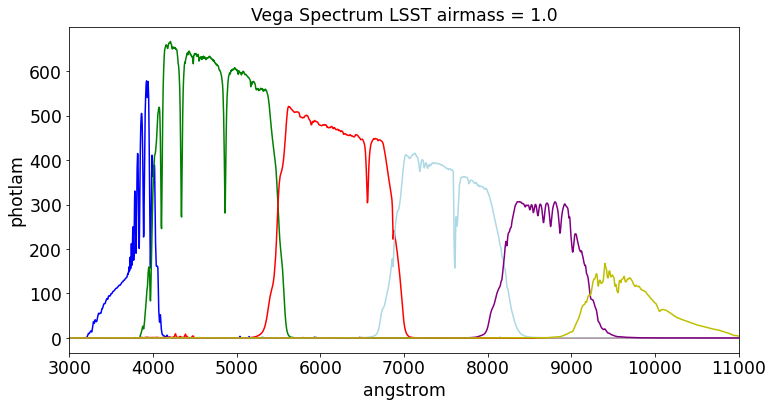

In [19]:
obs_u.convert('photlam')
obs_g.convert('photlam')
obs_r.convert('photlam')
obs_i.convert('photlam')
obs_z.convert('photlam')
obs_y.convert('photlam')

plt.plot(obs_u.binwave, obs_u.binflux, color = "b", label="u")
plt.plot(obs_g.binwave, obs_g.binflux, color = "g", label="g")
plt.plot(obs_r.binwave, obs_r.binflux, color = "r", label="r")
plt.plot(obs_i.binwave, obs_i.binflux, color = "lightblue", label="i")
plt.plot(obs_z.binwave, obs_z.binflux, color = "purple", label="z")
plt.plot(obs_y.binwave, obs_y.binflux, color = "y", label="y")
plt.xlim([3000,11000])
plt.xlabel(obs_r.waveunits)
plt.ylabel(obs_r.fluxunits) 
plt.title("Vega Spectrum LSST airmass = 1.0")

# Bandpass LSST x atmosphere without using pysynphot

Text(0.5, 1.0, 'Bandpass')

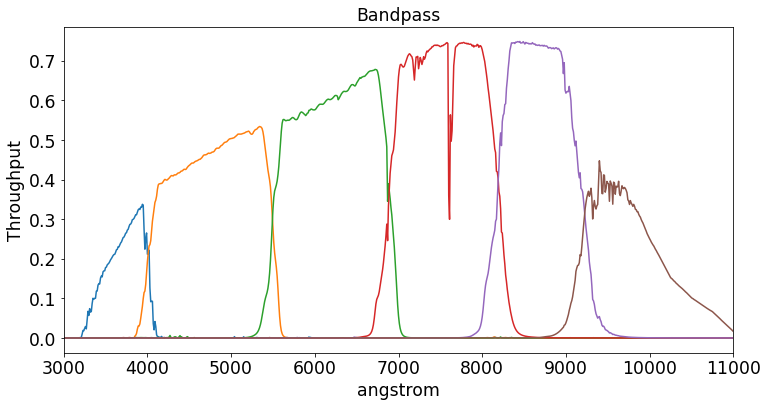

In [20]:
#Counts by hand

bandpass_u = []
bandpass_g = []
bandpass_r = []
bandpass_i = []
bandpass_z = []
bandpass_y = []

for i in range (50,951) :
        
    bandpass_u.append(df_LSST["u"][i-50] * throughput[i])
    bandpass_g.append(df_LSST["g"][i-50] * throughput[i])
    bandpass_r.append(df_LSST["r"][i-50] * throughput[i])
    bandpass_i.append(df_LSST["i"][i-50] * throughput[i])
    bandpass_z.append(df_LSST["z"][i-50] * throughput[i])
    bandpass_y.append(df_LSST["y"][i-50] * throughput[i])
    
       
plt.plot(Wavelength, bandpass_u)
plt.plot(Wavelength, bandpass_g)
plt.plot(Wavelength, bandpass_r)
plt.plot(Wavelength, bandpass_i)
plt.plot(Wavelength, bandpass_z)
plt.plot(Wavelength, bandpass_y)
plt.xlim([3000,11000])
plt.xlabel(bp_u.waveunits)
plt.ylabel("Throughput") 
plt.title("Bandpass")

# Interpolation Vega flux values for given wavelength

In [21]:
S.Vega.convert('photlam')

Vega_LSST = np.interp(Wavelength, S.Vega.wave, S.Vega.flux)

In [22]:
Spectrum = S.ArraySpectrum(Wavelength, Vega_LSST)

bandpass_y1 = S.ArrayBandpass(Wavelength, bandpass_y, name = "g")

obs_y1 = S.Observation(Spectrum, bandpass_y1)

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


# Vega Spectrum in photlam by hand

Text(0.5, 1.0, 'Vega Spectrum LSST airmass = 1.0')

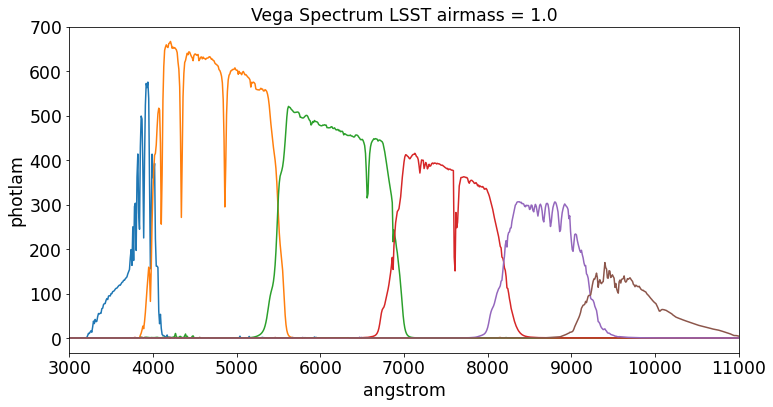

In [23]:
Vega_u = []
Vega_g = []
Vega_r = []
Vega_i = []
Vega_z = []
Vega_y = []


for i in range (len(Vega_LSST)) :
    
    Vega_u.append(Vega_LSST[i] * bandpass_u[i])
    Vega_g.append(Vega_LSST[i] * bandpass_g[i])
    Vega_r.append(Vega_LSST[i] * bandpass_r[i])
    Vega_i.append(Vega_LSST[i] * bandpass_i[i])
    Vega_z.append(Vega_LSST[i] * bandpass_z[i])
    Vega_y.append(Vega_LSST[i] * bandpass_y[i])
    
plt.plot(Wavelength, Vega_u)
plt.plot(Wavelength, Vega_g)
plt.plot(Wavelength, Vega_r)
plt.plot(Wavelength, Vega_i)
plt.plot(Wavelength, Vega_z)
plt.plot(Wavelength, Vega_y)
plt.xlim(3000,11000)
plt.xlabel(S.Vega.waveunits)
plt.ylabel(S.Vega.fluxunits) 
plt.title("Vega Spectrum LSST airmass = 1.0")


# Count in each band by hand 

In [24]:
count_u = 0
count_g = 0
count_r = 0
count_i = 0
count_z = 0
count_y = 0

for i in range (len(Vega_z)) : 
    count_u = count_u + Vega_u[i]*Seff*10             # x10 because the initial binning is 1 nm 
    count_g = count_g + Vega_g[i]*Seff*10
    count_r = count_r + Vega_r[i]*Seff*10
    count_i = count_i + Vega_i[i]*Seff*10
    count_z = count_z + Vega_z[i]*Seff*10
    count_y = count_y + Vega_y[i]*Seff*10
    
print("u count = ""{:2.3e} ".format(count_u))
print("g count = ""{:2.3e} ".format(count_g))
print("r count = ""{:2.3e} ".format(count_r))
print("i count = ""{:2.3e} ".format(count_i))
print("z count = ""{:2.3e} ".format(count_z))
print("y count = ""{:2.3e} ".format(count_y))

u count = 5.118e+10 
g count = 2.859e+11 
r count = 2.156e+11 
i count = 1.581e+11 
z count = 9.642e+10 
y count = 4.692e+10 


# Count in each band with countrate



In [25]:
print("u count = ""{:2.3e} ".format(obs_u.countrate()))
print("g count = ""{:2.3e} ".format(obs_g.countrate()))
print("r count = ""{:2.3e} ".format(obs_r.countrate()))
print("i count = ""{:2.3e} ".format(obs_i.countrate()))
print("z count = ""{:2.3e} ".format(obs_z.countrate()))
print("y count = ""{:2.3e} ".format(obs_y.countrate()))

u count = 5.113e+10 
g count = 2.861e+11 
r count = 2.156e+11 
i count = 1.582e+11 
z count = 9.684e+10 
y count = 5.448e+10 


# Calspec data through LSST 

In [26]:
Stisnic = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'hd14943_stis_005.fits')

In [27]:
Stisnic_spectrum = S.FileSpectrum(Stisnic)

Warning, 34 of 7206 bins contained negative fluxes; they have been set to zero.


In [28]:
obs_sti_u = S.Observation(Stisnic_spectrum, bp_u)
obs_sti_r = S.Observation(Stisnic_spectrum, bp_r)
obs_sti_g = S.Observation(Stisnic_spectrum, bp_g)
obs_sti_i = S.Observation(Stisnic_spectrum, bp_i)
obs_sti_z = S.Observation(Stisnic_spectrum, bp_z)
obs_sti_y = S.Observation(Stisnic_spectrum, bp_y)

((u * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


(0.0, 20000.0)

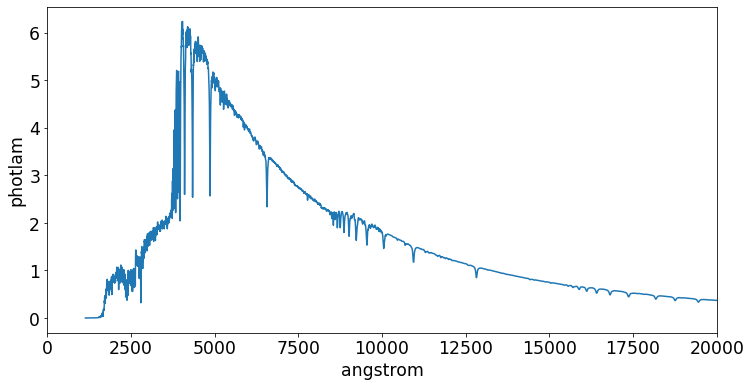

In [29]:
Stisnic_spectrum.convert('photlam')
plt.plot(Stisnic_spectrum.wave, Stisnic_spectrum.flux)
plt.xlabel(Stisnic_spectrum.waveunits)
plt.ylabel(Stisnic_spectrum.fluxunits)
plt.xlim([0,20000])

In [30]:
obs_sti_u.convert('photlam')
obs_sti_r.convert('photlam')
obs_sti_g.convert('photlam')
obs_sti_i.convert('photlam')
obs_sti_z.convert('photlam')
obs_sti_y.convert('photlam')

Text(0.5, 1.0, 'hd14943_stis_005.fits')

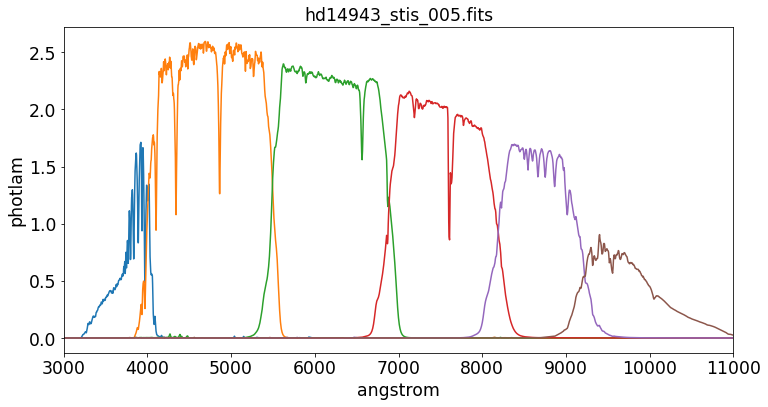

In [31]:
plt.plot(obs_sti_u.binwave,obs_sti_u.binflux)
plt.plot(obs_sti_g.binwave,obs_sti_g.binflux)
plt.plot(obs_sti_r.binwave,obs_sti_r.binflux)
plt.plot(obs_sti_i.binwave,obs_sti_i.binflux)
plt.plot(obs_sti_z.binwave,obs_sti_z.binflux)
plt.plot(obs_sti_y.binwave,obs_sti_y.binflux)
plt.xlim([3000,11000])
plt.xlabel(obs_sti_g.waveunits)
plt.ylabel(obs_sti_g.fluxunits)
plt.title(os.path.basename((Stisnic_spectrum.name)))

# Renormalization

In [32]:
Vega_renorm = S.Vega.renorm(20, 'abmag', S.ObsBandpass('johnson,v'))

Text(0, 0.5, 'photlam')

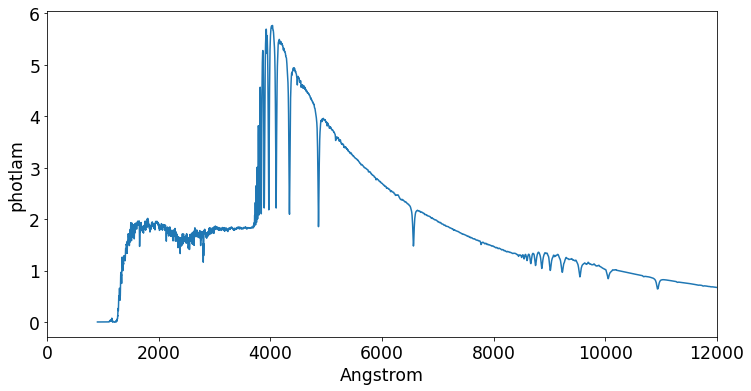

In [33]:
plt.plot(Vega_renorm.wave, Vega_renorm.flux*Seff)
#plt.plot(S.Vega.wave, S.Vega.flux*Seff)
plt.xlim([0,12000])
plt.xlabel('Angstrom')
plt.ylabel(Vega_renorm.fluxunits)

((g * atm, airmass 1.0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


(3000.0, 6000.0)

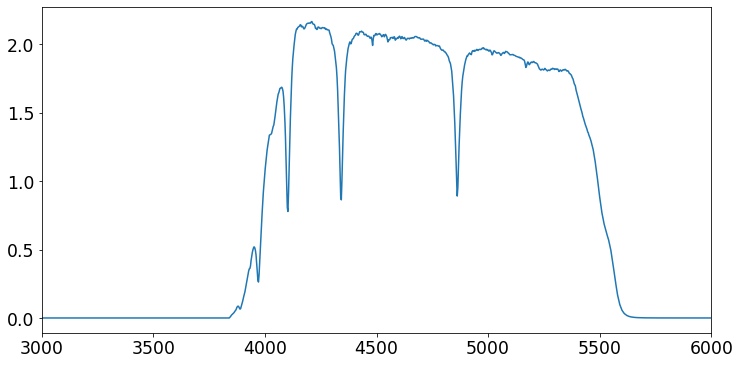

In [34]:
obse = S.Observation(Vega_renorm, bp_g)

plt.plot(obse.wave, obse.flux*Seff)
plt.xlim(3000,6000)

In [35]:
print(max(obse.flux*Seff))
print(max(Vega_renorm.flux*Seff))

2.165967971969386
5.762964770231054


# Error flux

In [36]:

m = 20
xerr = []
sigma_sys = 0.003
error_photo = []


for i in range (len(df)) :
    
    xerr.append( 10**(0.4*(m - df["fiveSigmaDepth"][i])))
    
    if (df["filter"][i] == "u") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.037) * xerr[i] + 0.037 * xerr[i]**2))  
   
    elif (df["filter"][i] == "g") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.038) * xerr[i] + 0.038 * xerr[i]**2))  
        
    elif (df["filter"][i] == "r") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.039) * xerr[i] + 0.039 * xerr[i]**2))  
        
    elif (df["filter"][i] == "i") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.039) * xerr[i] + 0.039 * xerr[i]**2))      
           
    elif (df["filter"][i] == "z") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.040) * xerr[i] + 0.040 * xerr[i]**2))     
        
    elif (df["filter"][i] == "y") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.040) * xerr[i] + 0.040 * xerr[i]**2))
        

In [37]:
from scipy import interpolate

temp = []
throughput = []
for i in range(0, 21):
    string = "D:\Projet de recherche\Stage\out\RT_MPL_pp_us_sa_rtvis_z" + str(10+i) + "_wv40_oz30_cld0000.out"
    f = open(string, 'r')
    temp.append([r.split() for r in f])
    throughput.append([float(r[1]) for r in temp[i]])

x = [float(r[0])*10 for r in temp[0]]
y = [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3] 

def atmo(wl, z) : 

    f = interpolate.interp2d(x, y, throughput)
    
    return float(f(wl,z))


In [38]:
#Atmo = [[] for i in range (len(df["observationId"]))]

#for i in range (len(df["observationStartMJD"])) :
    
    #for j in range (len(Wave)) :
        
        #Atmo[i].append(atmo(Wave[j], df["airmass"].values[i]))


In [39]:
#with open(r'D:\Projet de recherche\Stage\Baseline_SMCv1_Atmosphere.csv', 'w', newline='') as file:
    #writer = csv.writer(file)
    #big_boi = [[Wave[i]] + [t[i] for t in Atmo] for i in range(len(Wave))]
    #ObsStart = [i+1 for i in range (len(df["observationId"]))]
    #writer.writerow(ObsStart)
    #writer.writerows(big_boi)